<font size = '5'> <center> <u>**Tick tack toe using Reinforcement Learning**</u></center></font>

In this notebook, we will teach an agent to play tick tack toe using reinforcement learning. 

In [7]:
#first import all the libraries needed
from board import tick_tack_toe
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

First we will check the board out.

In [8]:
#initialize a game
game = tick_tack_toe()
game.print_board()

    |    |   
    |    |  
____|____|___
    |    |  
    |    |  
____|____|___
    |    |  
    |    |  
    |    |  


<u><font size = '3'> **Reinforcement Learning** </font></u>

The model will give values to the agent after each state. The state consist all the moves played by the agents at the end of a game. During training, agent 1 will be taught to play first and agent 2 second. In agent 1's memory we will store all the states that were rewarding to agent 1 and in agent 2's memory we will store all the states that were rewarding for agent 2. 

Agent 1 will be playing 'O' and agent 2 will be playing 'X'. An example of a state vector is below. 

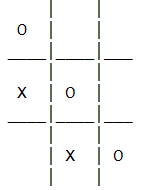

In the game above, agent 1 started first so the following state vector will be assigned to agent 1's memory with a reward of +1. 

state = [1, 4, 5, 8, 9]

since this is in player 1's memory 1 the player knows that the moves he/she played was 1, 5, 9 against moves 4 and 8 by agent 2. And since agent 1 won the game this will be a rewarding state for agent 1 whereas for agent 2, this will be a bad state to visit again. So we will assign -1 for agent 2 for this game. If the game is a draw both agents will recieve 0 points. 

So if the first iteration had the game above, player 1 and player 2 will have the following states stored. 

- Player 1 - [1, 4, 5, 8, 9] with a value of +1
- Player 2 - [1, 4, 5, 8, 9] with a value of -1


Now let's create some functions to select moves, store values etc.

<u>Selecting moves -</u> 

Each agent will select moves based on the values of the stored moves in each memory. If there is no games stored in the memory the agent will randomly select moves. The agent also want to explore so we will have the agent select random moves once in a while. 

In [9]:
#the first function will select moves

def choose_move(move_number, avail_moves, current_state, states, values, epsilon = 0.1):
    """
    inputs
    -------
    move_number - current move number (ranges from 1 - 9)
    avail_moves - moves that are available to choose from
    current_state - the current state vector of the game
    states - memory with the already played states
    values - an array containing the values of each of those states in the memory
    epsilon - the probability the algorithm will explore new moves
    
    output
    -------
    action - this function outputs the most rewarding move
    """
    
    #exploration. choose 0 and 1 with a given probability. and explore if 0 is chosen
    explore = np.random.choice([0, 1], p = [epsilon, 1 - epsilon])
    
    if explore == 0:
        
        #randomly choose action
        action = np.random.choice(avail_moves)
    
    else:
        
        #get all the indices from the states that is equal to the current state of the game
        v = []
        idx = []
                   
        for i, state in enumerate(states):
            st = state[:move_number]
            
            if st == current_state:
                v.append(values[i])          
                idx.append(i)
                
        #find the maximum value
        if (v == []) == True:
            action = np.random.choice(avail_moves)
            
        else:
            max_val_idx = np.argmax(v)
            max_idx = idx[max_val_idx]
            action = states[max_idx][move_number]
            
    return action

We'll run some hypothetical situations to see if the choose_move function is working properly. We will use two example situations and will run multile iterations and plot the moves selected by the function. 

First we will create some hypothetical states and their values vectors. 

states = [[3, 1, 4, 5, 6], [1, 2, 5, 6, 4], [1, 2, 3, 6]]

values = [8, 9, 1]

<u>**Scenario 1**</u>

move_number = 1

available_moves = [3, 6, 0, 1]

current_state = [1]

In this situation, the current state is 1 and there are two games in the memory (states vector) that we already played move 1 first. If we look at the values vector the respective values for those two states are 9 and 1, so ideally the function should choose the next move from the state that has the highest value. So the algorithm will choose move 2 frequently in this situation.

<u>**Scenario 2**</u>

move_number = 3

available_moves = [3, 6, 0, 1]

current_state = [1, 2]

In this situation, the current state is [1, 2]. There are two moves played so the function will choose the third move. Out of states already played there are two states that 1 and 2 were played. Out of those two states the state [1, 2, 5, 6, 4] has the highest reward (9) so the algorithm will frequently choose move 5 to maximize reward.

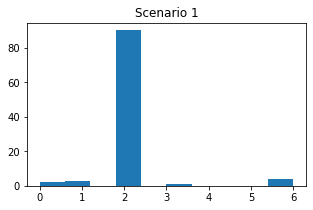

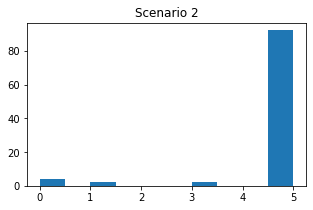

In [10]:
#states and values
states = [[3, 1, 4, 5, 6], [1, 2, 5, 6, 4], [1, 2, 3, 6]]
values = [8, 9, 1]

#available moves
available_moves =  [3, 6, 0, 1]

#situation 1
current_state = [1]
move_number = len(current_state)

selected_move = []

for i in range(100):
    selected_move.append(choose_move(move_number, available_moves, current_state, states, values))
    
#plot the distribution
plt.figure(figsize = (5, 3))
plt.hist(selected_move)
plt.title('Scenario 1')
plt.show()

#situation 2
current_state = [1, 2]
move_number = len(current_state)

selected_move = []

for i in range(100):
    selected_move.append(choose_move(move_number, available_moves, current_state, states, values))
    
#plot the distribution
plt.figure(figsize = (5, 3))
plt.hist(selected_move)
plt.title('Scenario 2')
plt.show()

As expected the agent has selected move 2 in scenario 1 and move 5 in scenario 2. So the function seems to collect the moves correctly. 

Now let's create a function that rewards for winning states and penalizes losing states.

In [22]:
#function to give the rewards

def give_reward(states_and_values, moves, reward, alpha = 0.2):
    
    """
    inputs
    ---------
    states_and_values - a dictionary containing states and each state's values
    moves - a list containing the current_state moves
    reward - the reward awarded 
    alpha - the learning_rate by default set to 0.5
    
    output
    -------
    states_and_values - a dictionary after the moves with the new reward added
    """
    
    if tuple(moves) in states_and_values.keys():
        states_and_values[tuple(moves)] += alpha * (reward)
    else:
        states_and_values[tuple(moves)] = reward
        
    return states_and_values
    

Now Let's try to create a self play algorithm where two agents are playing together

In [28]:
#player 1 memory
player1 = {}
p1_wins = []
states1 = []
values1 = []

player2 = {}
p2_wins = []
states2 = []
values2 = []

#number of iterations of self play
num_its = 10**5


for i in range(num_its):
    
    #player 1 is always first
    player = 1
    
    #game_on
    game_on = True
      
    #initialize the game
    game = tick_tack_toe()

    #intial values
    move_number = 1
    avail_moves = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    current_state = []
    winner = ''

    while move_number < 10:
        

        #if a winner is declared by the game.check_winner() the game will stop and will assign the rewards
        if (winner == 'X') or (winner == 'O'):
            
            #print the end game after every 2000th iteration
            if i % 10000 == 0:

                game.print_board()


            break
        
        #choose move for each player
        
        if player == 1:
            move = choose_move(move_number, avail_moves, current_state, states1, values1, epsilon = 0.04)
        
        elif player == 2:
            move = choose_move(move_number, avail_moves, current_state, states2, values2, epsilon = 0.04)
        
        #play the move
        _, avail_moves = game.play(move, player)
        winner = game.check_winner()
        #game.print_board()
        #clear_output()

        #change the move number
        move_number = move_number + 1
        #append the move to the current state
        current_state.append(move)
        
        #switch turns
        if player == 1:
            player = 2
        elif player == 2:
            player = 1
    
    if winner == 'O':
        
        #player 1
        player1 = give_reward(player1, current_state, 1)        
        states_tup1 = player1.keys()
        states1 = [list(s) for s in states_tup1]
        values1 = list(player1.values())
              
        #player 2
        player2 = give_reward(player2, current_state, -1)
        states_tup2 = player2.keys()
        states2 = [list(s) for s in states_tup2]
        values2 = list(player2.values())
        p1_wins.append(1)
        p2_wins.append(0)
        
    elif winner == 'X':
        
        #Player 2
        player2 = give_reward(player2, current_state, 1)
        states_tup2 = player2.keys()
        states2 = [list(s) for s in states_tup2]
        values2 = list(player2.values())
    
        #player 1
        player1 = give_reward(player1, current_state, -1)
        states_tup1 = player1.keys()
        states1 = [list(s) for s in states_tup1]
        values1 = list(player1.values())
        
        p1_wins.append(0)
        p2_wins.append(1)
        
        
    elif winner == '':
        print('draw')
        #player 1
        player1 = give_reward(player1, current_state, 0)
        states_tup1 = player1.keys()
        states1 = [list(s) for s in states_tup1]
        values1 = list(player1.values())
        
        #player 2
        player2 = give_reward(player2, current_state, 0)
        states_tup2 = player2.keys()
        states2 = [list(s) for s in states_tup2]
        values2 = list(player2.values())
        
        p1_wins.append(0)
        p2_wins.append(0)

    |    |   
    | O  | O
____|____|___
    |    |  
 X  | O  | X
____|____|___
    |    |  
 O  | X  |  
    |    |  


KeyboardInterrupt: 

In [30]:
sum(p1_wins)/len(p1_wins)

0.6766824181196024

In [31]:
sum(p2_wins)/len(p2_wins)

0.3233175818803976

(array([1.0000e+00, 1.6000e+01, 1.0800e+02, 7.4900e+02, 8.0300e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.5306e+04, 1.5370e+03, 0.0000e+00, 3.3900e+02,
        1.8300e+02, 8.3000e+01, 2.7000e+01, 6.0000e+00, 2.0000e+00]),
 array([-1.8  , -1.632, -1.464, -1.296, -1.128, -0.96 , -0.792, -0.624,
        -0.456, -0.288, -0.12 ,  0.048,  0.216,  0.384,  0.552,  0.72 ,
         0.888,  1.056,  1.224,  1.392,  1.56 ,  1.728,  1.896,  2.064,
         2.232,  2.4  ]),
 <BarContainer object of 25 artists>)

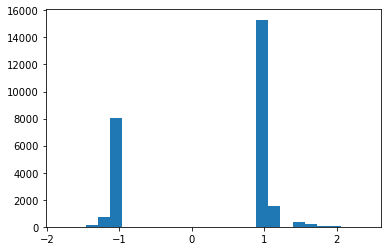

In [35]:
plt.hist(values1, bins = 25)

In [ ]:
#states and values
states = [[3, 1, 4, 5, 6], [1, 2, 5, 6, 4], [1, 2, 3, 6]]
values = [8, 9, 1]

#available moves
available_moves =  [3, 6, 0, 1]

#situation 1
current_state = [1, 2]

s